# Edge Based Exposure Grouping

In [3]:
from cv2 import GaussianBlur, Laplacian, CV_64F
from numpy import absolute, float64, interp, maximum, uint8, unique

def laplacian_of_gaussain (input):
    smooth = GaussianBlur(input, (3, 3), 0)
    response = Laplacian(smooth, CV_64F)
    return response

def histogram_match (input, target):
    # Source: https://stackoverflow.com/questions/32655686/histogram-matching-of-two-images-in-python-2-x
    s_values, bin_idx, s_counts = unique(input.ravel(), return_inverse=True, return_counts=True)
    t_values, t_counts = unique(target.ravel(), return_counts=True)
    s_quantiles = s_counts.cumsum().astype(float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = t_counts.cumsum().astype(float64)
    t_quantiles /= t_quantiles[-1]
    interp_t_values = interp(s_quantiles, t_quantiles, t_values)
    result = interp_t_values[bin_idx].reshape(input.shape)
    return result

def equalized_exposure (image_a, image_b):
    std_a, std_b = image_a.std(), image_b.std()
    input, target = (image_a, image_b) if std_a < std_b else (image_b, image_a)
    matched = histogram_match(input, target).astype(uint8)
    return matched, target

def detail_delta (image_a, image_b):
    query, target = equalized_exposure(image_a, image_b)
    average = 0.5 * query + 0.5 * target
    input_response = laplacian_of_gaussain(target)
    average_response = laplacian_of_gaussain(average)
    input_response, average_response = absolute(input_response), absolute(average_response)
    delta = absolute(input_response - average_response).sum() / input_response.size
    return delta

## Images


In [1]:
from cv2 import imread, resize, INTER_AREA

# Test images
images = [imread(f"../test/media/group/{i+1}.jpg", 0) for i in range(0, 24)]
images = [resize(image, (512, 512), interpolation=INTER_AREA) for image in images]

In [95]:
from cv2 import imread, resize, INTER_AREA

# Troon images
images = [imread(f"/Users/yusuf/Desktop/16 Troon Way/brackets/{i+1}.jpg", 0) for i in range(0, 108)]
images = [resize(image, (512, 512), interpolation=INTER_AREA) for image in images]

## Algorithm

Delta: 4.766079667382542


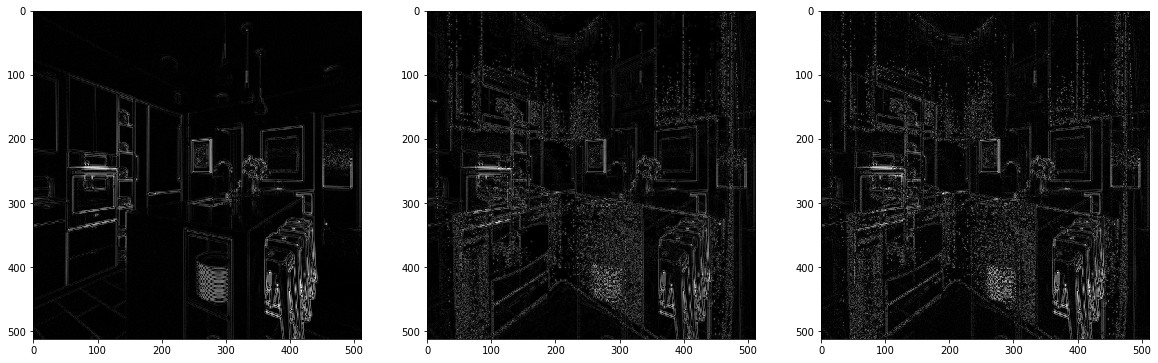

In [28]:
from matplotlib import pyplot as plt

image_a, image_b = images[4], images[5]
matched, target = equalized_exposure(image_a, image_b)
average = 0.5 * matched + 0.5 * target
input_response = laplacian_of_gaussain(target)
average_response = laplacian_of_gaussain(average)
input_response, average_response = absolute(input_response), absolute(average_response)
delta = absolute(input_response - average_response)

plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.imshow(input_response, cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(average_response, cmap="gray")
plt.subplot(1, 3, 3)
plt.imshow(delta, cmap="gray")

print("Delta:", delta.sum() / delta.size)

In [7]:
from cv2 import Canny, GaussianBlur
from numpy import median

def auto_canny (image, sigma=0.33):
	# v = median(image)
	# lower = int(max(0, (1.0 - sigma) * v))
	# upper = int(min(255, (1.0 + sigma) * v))
    #image = GaussianBlur(image, (5, 5), 0)
    image = GaussianBlur(image, (5, 5), 0)
    edges = Canny(image, 50, 150)
    return edges

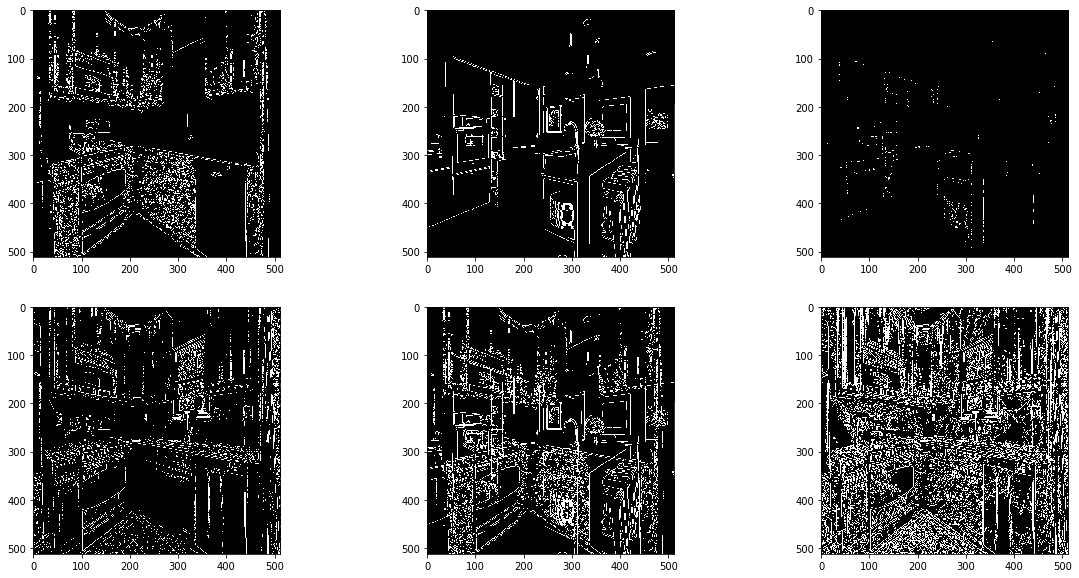

In [56]:
image_a, image_b, image_c = images[4], images[5], images[6]
matched, target = equalized_exposure(image_a, image_b)

edges_a, edges_b = auto_canny(matched), auto_canny(target)

matched_b, target_b = equalized_exposure(image_b, image_c)
edges_d, edges_e = auto_canny(matched_b), auto_canny(target_b)
intersection_b = edges_d & edges_e
union_b = edges_d | edges_e

intersection = edges_a & edges_b
union = edges_a | edges_b

plt.figure(figsize=(20, 10))
plt.subplot(2, 3, 1)
plt.imshow(edges_a, cmap="gray")
plt.subplot(2, 3, 2)
plt.imshow(edges_b, cmap="gray")
plt.subplot(2, 3, 3)
plt.imshow(intersection, cmap="gray")
plt.subplot(2, 3, 4)
plt.imshow(intersection_b, cmap="gray")
plt.subplot(2, 3, 5)
plt.imshow(union, cmap="gray")
plt.subplot(2, 3, 6)
plt.imshow(union_b, cmap="gray")

In [5]:
def detail_intersection (image_a, image_b):
    # Equalize
    matched, target = equalized_exposure(image_a, image_b)
    # Compute edge intersection
    matched_edges, target_edges = auto_canny(matched), auto_canny(target)
    intersection = matched_edges & target_edges
    # Compute ratios
    ratio_a = intersection[matched_edges > 0].sum() / matched_edges[matched_edges > 0].sum()
    ratio_b = intersection[target_edges > 0].sum() / target_edges[target_edges > 0].sum()
    return max(ratio_a, ratio_b)

## Test

In [8]:
for i in range(len(images) - 1):
    print(f"{i+1} -> {i+2}:", detail_intersection(images[i], images[i+1]))

1 -> 2: 0.9189871420683127
2 -> 3: 0.8576675026872089
3 -> 4: 0.7275437942601566
4 -> 5: 0.8934419745273317
5 -> 6: 0.09728918043151821
6 -> 7: 0.8816005247622172
7 -> 8: 0.8690990018883193
8 -> 9: 0.6951624454717104
9 -> 10: 0.7887864348041339
10 -> 11: 0.05909547738693467
11 -> 12: 0.699497487437186
12 -> 13: 0.4117851555710064
13 -> 14: 0.03380009657170449
14 -> 15: 0.9084279736999402
15 -> 16: 0.8582014820749049
16 -> 17: 0.04981653965565905
17 -> 18: 0.4658481512842224
18 -> 19: 0.1457251158219851
19 -> 20: 0.5651731160896131
20 -> 21: 0.6107652022112308
21 -> 22: 0.2050956882637768
22 -> 23: 0.8839531387399654
23 -> 24: 0.8657439446366783


In [93]:
def group_exposures (images, min_similarity=0.35):
    groups = []
    current_group = [images[0]]
    for i in range(1, len(images)):
        similarity = detail_intersection(images[i-1], images[i])
        if (similarity < min_similarity):
            groups.append(current_group)
            current_group = []
        current_group.append(images[i])
    groups.append(current_group)
    return groups

In [96]:
# Group
groups = group_exposures(images)
[len(group) for group in groups]

[3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3]